In [118]:
import pandas as pd
import main as main
import numpy as np
import holidays
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error

In [2]:
%matplotlib inline

In [3]:
data = pd.read_csv('BikeSharing_Bluebikes2022.csv', index_col=0)

/home/georgep/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code
0,597,2022-01-01 00:00:25.1660,2022-01-01 00:10:22.1920,178,MIT Pacific St at Purrington St,42.359573,-71.101295,74,Harvard Square at Mass Ave/ Dunster,42.373268,-71.118579,4923,Subscriber,02139
1,411,2022-01-01 00:00:40.4300,2022-01-01 00:07:32.1980,189,Kendall T,42.362428,-71.084955,178,MIT Pacific St at Purrington St,42.359573,-71.101295,3112,Subscriber,02139
2,476,2022-01-01 00:00:54.8180,2022-01-01 00:08:51.6680,94,Main St at Austin St,42.375603,-71.064608,356,Charlestown Navy Yard,42.374125,-71.054812,6901,Customer,02124
3,466,2022-01-01 00:01:01.6080,2022-01-01 00:08:48.2350,94,Main St at Austin St,42.375603,-71.064608,356,Charlestown Navy Yard,42.374125,-71.054812,5214,Customer,02124
4,752,2022-01-01 00:01:06.0520,2022-01-01 00:13:38.2300,19,Park Dr at Buswell St,42.347241,-71.105301,41,Packard's Corner - Commonwealth Ave at Brighto...,42.352261,-71.123831,2214,Subscriber,02215


In [5]:
#transforming the dates from object to datetime
for date_column in ['starttime','stoptime']:
    data[date_column] = pd.to_datetime(data[date_column], format='%Y-%m-%d %H:%M:%S')

### Weather Data

In [6]:
weather_data = pd.read_csv('Data/WeatherData', index_col=0)

In [7]:
weather_data.head()

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,Boston,2022-01-01T00:00:00,7.8,7.8,6.7,92.50,0.0,0,NaN,0.0,...,1014.5,100.0,8.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."
1,Boston,2022-01-01T01:00:00,7.2,6.5,6.7,96.49,0.0,0,NaN,0.0,...,1014.1,100.0,5.1,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."
2,Boston,2022-01-01T02:00:00,7.2,6.0,6.7,96.49,0.0,0,NaN,0.0,...,1014.2,100.0,4.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."
3,Boston,2022-01-01T03:00:00,7.2,7.2,6.7,96.60,0.0,0,NaN,0.0,...,1014.1,100.0,1.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."
4,Boston,2022-01-01T04:00:00,6.8,5.4,6.7,99.79,0.0,0,NaN,0.0,...,1013.6,100.0,0.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."


In [8]:
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'], format='%Y-%m-%dT%H:%M:%S')
weather_data.drop('name',axis=1, inplace=True)
weather_data.set_index('datetime', inplace=True)

In [9]:
weather_data.head()

,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,7.8,7.8,6.7,92.50,0.0,0,NaN,0.0,0.0,NaN,...,1014.5,100.0,8.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."
2022-01-01 01:00:00,7.2,6.5,6.7,96.49,0.0,0,NaN,0.0,0.0,NaN,...,1014.1,100.0,5.1,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."
2022-01-01 02:00:00,7.2,6.0,6.7,96.49,0.0,0,NaN,0.0,0.0,NaN,...,1014.2,100.0,4.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."
2022-01-01 03:00:00,7.2,7.2,6.7,96.60,0.0,0,NaN,0.0,0.0,NaN,...,1014.1,100.0,1.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."
2022-01-01 04:00:00,6.8,5.4,6.7,99.79,0.0,0,NaN,0.0,0.0,NaN,...,1013.6,100.0,0.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."


In [10]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5831 entries, 2022-01-01 00:00:00 to 2022-08-31 23:00:00
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp              5831 non-null   float64
 1   feelslike         5831 non-null   float64
 2   dew               5831 non-null   float64
 3   humidity          5831 non-null   float64
 4   precip            5831 non-null   float64
 5   precipprob        5831 non-null   int64  
 6   preciptype        547 non-null    object 
 7   snow              5831 non-null   float64
 8   snowdepth         5831 non-null   float64
 9   windgust          5675 non-null   float64
 10  windspeed         5831 non-null   float64
 11  winddir           5831 non-null   float64
 12  sealevelpressure  5831 non-null   float64
 13  cloudcover        5831 non-null   float64
 14  visibility        5831 non-null   float64
 15  solarradiation    5691 non-null   float64
 16  solare

In [11]:
weather_data.isna().sum()

temp                   0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
preciptype          5284
snow                   0
snowdepth              0
windgust             156
windspeed              0
winddir                0
sealevelpressure       0
cloudcover             0
visibility             0
solarradiation       140
solarenergy         2547
uvindex              140
severerisk           230
conditions             0
icon                   0
stations               0
dtype: int64

In [12]:
weather_data.head()

,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,7.8,7.8,6.7,92.50,0.0,0,NaN,0.0,0.0,NaN,...,1014.5,100.0,8.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."
2022-01-01 01:00:00,7.2,6.5,6.7,96.49,0.0,0,NaN,0.0,0.0,NaN,...,1014.1,100.0,5.1,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."
2022-01-01 02:00:00,7.2,6.0,6.7,96.49,0.0,0,NaN,0.0,0.0,NaN,...,1014.2,100.0,4.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."
2022-01-01 03:00:00,7.2,7.2,6.7,96.60,0.0,0,NaN,0.0,0.0,NaN,...,1014.1,100.0,1.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."
2022-01-01 04:00:00,6.8,5.4,6.7,99.79,0.0,0,NaN,0.0,0.0,NaN,...,1013.6,100.0,0.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."


temp

In [13]:
weather_data['temp'].describe()

count    5831.000000
mean       12.352478
std        11.056270
min       -15.600000
25%         4.300000
50%        12.900000
75%        21.600000
max        37.200000
Name: temp, dtype: float64

feelslike

In [14]:
weather_data['feelslike'].describe()

count    5831.000000
mean       10.596210
std        13.410548
min       -26.500000
25%         0.800000
50%        12.900000
75%        21.600000
max        39.500000
Name: feelslike, dtype: float64

Humidity

In [15]:
weather_data['humidity'].describe()

count    5831.000000
mean       62.503353
std        20.229678
min        15.130000
25%        46.120000
50%        61.270000
75%        79.645000
max        99.940000
Name: humidity, dtype: float64

precip

In [16]:
weather_data['precip'].describe()

count    5831.000000
mean        0.077047
std         0.451573
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        10.546000
Name: precip, dtype: float64

In [17]:
weather_data[weather_data['precip']>0]['conditions'].unique()

array(['Rain, Overcast', 'Snow, Rain, Overcast', 'Snow, Overcast',
       'Rain, Partially cloudy', 'Snow, Ice, Overcast',
       'Snow, Partially cloudy'], dtype=object)

snow

In [18]:
weather_data['snow'].describe()

count    5831.000000
mean        0.019317
std         0.142421
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         6.600000
Name: snow, dtype: float64

In [19]:
weather_data[weather_data['snow']>2]['conditions'].unique()

array(['Partially cloudy'], dtype=object)

Preciptype

In [20]:
weather_data['preciptype'].nunique()

5

In [21]:
weather_data['preciptype'].unique()

array([nan, 'rain', 'rain,snow', 'snow', 'freezingrain', 'snow,ice'],
      dtype=object)

In [22]:
weather_data[weather_data['preciptype']=='snow'][['snow','snowdepth']]

,snow,snowdepth
datetime,,
2022-01-07 05:00:00,1.04,21.88
2022-01-24 00:00:00,0.00,0.10
2022-01-25 00:00:00,0.13,2.00
2022-01-25 01:00:00,0.13,2.13
2022-01-29 02:00:00,0.42,7.50
...,...,...
2022-03-03 03:00:00,0.70,13.42
2022-03-03 04:00:00,1.10,13.33
2022-03-03 05:00:00,0.40,13.25


In [23]:
weather_data['enc_preciptype'] = weather_data['preciptype'].map(lambda row: main.PreciptypeMap(row))

In [24]:
weather_data.head()

,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,...,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations,enc_preciptype
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,7.8,7.8,6.7,92.50,0.0,0,NaN,0.0,0.0,NaN,...,100.0,8.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591...",0
2022-01-01 01:00:00,7.2,6.5,6.7,96.49,0.0,0,NaN,0.0,0.0,NaN,...,100.0,5.1,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591...",0
2022-01-01 02:00:00,7.2,6.0,6.7,96.49,0.0,0,NaN,0.0,0.0,NaN,...,100.0,4.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591...",0
2022-01-01 03:00:00,7.2,7.2,6.7,96.60,0.0,0,NaN,0.0,0.0,NaN,...,100.0,1.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591...",0
2022-01-01 04:00:00,6.8,5.4,6.7,99.79,0.0,0,NaN,0.0,0.0,NaN,...,100.0,0.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591...",0


Conditions

In [25]:
weather_data['conditions'].unique()

array(['Overcast', 'Rain, Overcast', 'Partially cloudy', 'Clear',
       'Snow, Rain, Overcast', 'Snow, Overcast', 'Rain, Partially cloudy',
       'Snow, Ice, Overcast', 'Snow, Partially cloudy'], dtype=object)

In [26]:
weather_data['enc_conditions'] = weather_data['conditions'].map(lambda row: main.ConditionsMap(row))

In [27]:
weather_data.head()

,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,...,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations,enc_preciptype,enc_conditions
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,7.8,7.8,6.7,92.50,0.0,0,NaN,0.0,0.0,NaN,...,8.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591...",0,1
2022-01-01 01:00:00,7.2,6.5,6.7,96.49,0.0,0,NaN,0.0,0.0,NaN,...,5.1,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591...",0,1
2022-01-01 02:00:00,7.2,6.0,6.7,96.49,0.0,0,NaN,0.0,0.0,NaN,...,4.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591...",0,1
2022-01-01 03:00:00,7.2,7.2,6.7,96.60,0.0,0,NaN,0.0,0.0,NaN,...,1.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591...",0,1
2022-01-01 04:00:00,6.8,5.4,6.7,99.79,0.0,0,NaN,0.0,0.0,NaN,...,0.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591...",0,1


Severerisk

In [28]:
weather_data['severerisk'].unique()

array([nan, 10.,  3.,  5., 30., 15.,  8., 60., 75.])

In [29]:
weather_data['severerisk'].fillna(weather_data['severerisk'].median(), inplace=True)

solar radiation

In [30]:
weather_data['solarradiation'].unique()

array([      nan, 1.100e+01, 2.400e+01, 2.100e+01, 2.600e+01, 2.700e+01,
       4.500e+01, 3.200e+01, 1.200e+01, 7.000e+00, 2.500e+01, 3.600e+01,
       7.000e+01, 8.200e+01, 4.300e+01, 5.000e+01, 3.000e+01, 9.000e+00,
       5.200e+01, 6.400e+01, 7.400e+01, 6.800e+01, 4.000e+01, 3.900e+01,
       1.800e+01, 2.300e+01, 1.540e+02, 2.750e+02, 3.530e+02, 3.800e+02,
       3.660e+02, 3.010e+02, 2.360e+02, 1.600e+01, 5.000e+00, 3.700e+01,
       1.050e+02, 1.110e+02, 7.500e+01, 5.600e+01, 7.200e+01, 4.400e+01,
       1.500e+01, 2.580e+02, 3.190e+02, 2.220e+02, 1.970e+02, 1.990e+02,
       1.270e+02, 2.000e+01, 1.000e+01, 3.500e+01, 5.300e+01, 1.450e+02,
       9.800e+01, 6.700e+01, 1.350e+02, 2.820e+02, 3.630e+02, 3.950e+02,
       3.810e+02, 2.720e+02, 1.860e+02, 1.700e+01, 2.900e+01, 5.700e+01,
       1.920e+02, 1.520e+02, 9.200e+01, 1.340e+02, 2.860e+02, 3.960e+02,
       4.010e+02, 3.990e+02, 3.150e+02, 1.480e+02, 3.300e+01, 0.000e+00,
       1.330e+02, 3.170e+02, 3.670e+02, 3.790e+02, 

In [31]:
weather_data['solarradiation'].min()

0.0

In [32]:
#weather_data[weather_data['solarradiation'].isna()==True]
weather_data[weather_data['solarradiation']==0.0]['severerisk'].unique()

array([10.,  3.,  5., 15., 30., 60.,  8.])

In [33]:
weather_data[weather_data['solarradiation']==0.0]['enc_conditions'].unique()

array([1, 2, 3])

In [34]:
weather_data[weather_data['solarradiation'].isna()==True]['severerisk'].unique()

array([10.])

In [35]:
sorted(weather_data[weather_data['solarradiation'].isna()==True].index)

[Timestamp('2022-01-01 00:00:00'),
 Timestamp('2022-01-01 01:00:00'),
 Timestamp('2022-01-01 02:00:00'),
 Timestamp('2022-01-01 03:00:00'),
 Timestamp('2022-01-01 04:00:00'),
 Timestamp('2022-01-01 05:00:00'),
 Timestamp('2022-01-01 06:00:00'),
 Timestamp('2022-01-01 07:00:00'),
 Timestamp('2022-01-01 17:00:00'),
 Timestamp('2022-01-01 18:00:00'),
 Timestamp('2022-01-01 19:00:00'),
 Timestamp('2022-01-01 20:00:00'),
 Timestamp('2022-01-01 21:00:00'),
 Timestamp('2022-01-01 22:00:00'),
 Timestamp('2022-01-01 23:00:00'),
 Timestamp('2022-01-02 00:00:00'),
 Timestamp('2022-01-02 01:00:00'),
 Timestamp('2022-01-02 02:00:00'),
 Timestamp('2022-01-02 03:00:00'),
 Timestamp('2022-01-02 04:00:00'),
 Timestamp('2022-01-02 05:00:00'),
 Timestamp('2022-01-02 06:00:00'),
 Timestamp('2022-01-02 07:00:00'),
 Timestamp('2022-01-02 17:00:00'),
 Timestamp('2022-01-02 18:00:00'),
 Timestamp('2022-01-02 19:00:00'),
 Timestamp('2022-01-02 20:00:00'),
 Timestamp('2022-01-02 21:00:00'),
 Timestamp('2022-01-

In [36]:
weather_data['solarradiation'].fillna(0.0, inplace=True)

UVindex

In [37]:
weather_data['uvindex'].unique()

array([nan,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [38]:
sorted(weather_data[weather_data['uvindex'].isna()==True].index)

[Timestamp('2022-01-01 00:00:00'),
 Timestamp('2022-01-01 01:00:00'),
 Timestamp('2022-01-01 02:00:00'),
 Timestamp('2022-01-01 03:00:00'),
 Timestamp('2022-01-01 04:00:00'),
 Timestamp('2022-01-01 05:00:00'),
 Timestamp('2022-01-01 06:00:00'),
 Timestamp('2022-01-01 07:00:00'),
 Timestamp('2022-01-01 17:00:00'),
 Timestamp('2022-01-01 18:00:00'),
 Timestamp('2022-01-01 19:00:00'),
 Timestamp('2022-01-01 20:00:00'),
 Timestamp('2022-01-01 21:00:00'),
 Timestamp('2022-01-01 22:00:00'),
 Timestamp('2022-01-01 23:00:00'),
 Timestamp('2022-01-02 00:00:00'),
 Timestamp('2022-01-02 01:00:00'),
 Timestamp('2022-01-02 02:00:00'),
 Timestamp('2022-01-02 03:00:00'),
 Timestamp('2022-01-02 04:00:00'),
 Timestamp('2022-01-02 05:00:00'),
 Timestamp('2022-01-02 06:00:00'),
 Timestamp('2022-01-02 07:00:00'),
 Timestamp('2022-01-02 17:00:00'),
 Timestamp('2022-01-02 18:00:00'),
 Timestamp('2022-01-02 19:00:00'),
 Timestamp('2022-01-02 20:00:00'),
 Timestamp('2022-01-02 21:00:00'),
 Timestamp('2022-01-

In [39]:
weather_data['uvindex'].fillna(0.0, inplace=True)

In [40]:
weather_data.drop(['dew','sealevelpressure','cloudcover','solarenergy','icon','windgust','winddir','solarradiation','precipprob','conditions','preciptype','stations'], axis=1, inplace=True)

In [41]:
weather_data.head()

,temp,feelslike,humidity,precip,snow,snowdepth,windspeed,visibility,uvindex,severerisk,enc_preciptype,enc_conditions
datetime,,,,,,,,,,,,
2022-01-01 00:00:00,7.8,7.8,92.50,0.0,0.0,0.0,0.1,8.0,0.0,10.0,0,1
2022-01-01 01:00:00,7.2,6.5,96.49,0.0,0.0,0.0,5.3,5.1,0.0,10.0,0,1
2022-01-01 02:00:00,7.2,6.0,96.49,0.0,0.0,0.0,7.3,4.0,0.0,10.0,0,1
2022-01-01 03:00:00,7.2,7.2,96.60,0.0,0.0,0.0,0.1,1.0,0.0,10.0,0,1
2022-01-01 04:00:00,6.8,5.4,99.79,0.0,0.0,0.0,7.4,0.0,0.0,10.0,0,1


In [42]:
weather_data15 = weather_data.resample('15Min').fillna(method='ffill')
weather_data30 = weather_data.resample('20Min').fillna(method='ffill')
weather_data60 = weather_data
weather_data120 = weather_data.resample('2H').mean()

# Connect Data

In [43]:
df15 = main.DatetimeInterval(data, freq='15Min')
df30 = main.DatetimeInterval(data, freq='30Min')
df60 = main.DatetimeInterval(data, freq='60Min')
df120 = main.DatetimeInterval(data, freq='120Min')

In [44]:
weather_data15 = weather_data.resample('15Min').fillna(method='ffill')
weather_data30 = weather_data.resample('30Min').fillna(method='ffill')
weather_data60 = weather_data
weather_data120 = weather_data.resample('2H').mean()

In [45]:
picksup15 = main.MergingDataFrames(weather_data15, df15)
picksup30 = main.MergingDataFrames(weather_data30, df30)
picksup60 = main.MergingDataFrames(weather_data60, df60)
picksup120 = main.MergingDataFrames(weather_data120, df120)

Weekend/Weekday & Holidays & Month/Hour/Minute & Season

In [46]:
season_month =  {1:'Winter', 2:'Winter',
                3:'Spring', 4:'Spring', 5:'Spring',
                6:'Summer', 7:'Summer', 8:'Summer'}

In [47]:
for pickup in [picksup15,picksup30, picksup60, picksup120]:
    pickup = main.DataPreprocess(pickup, season_month)
    pickup = pd.get_dummies(pickup, 'season')

In [48]:
picksup15 = pd.get_dummies(picksup15, 'season')
picksup30 = pd.get_dummies(picksup30, 'season')
picksup60 = pd.get_dummies(picksup60, 'season')
picksup120 = pd.get_dummies(picksup120, 'season')
picksup15 = main.Lagging(picksup15, 15)
picksup30 = main.Lagging(picksup30, 30)
picksup60 = main.Lagging(picksup60, 60)
picksup120 = main.Lagging(picksup120, 120)

# EDA 

In [74]:
picksup = picksup30.copy()

In [50]:
picksup.dropna(inplace=True)

In [51]:
picksup.describe()

,temp,feelslike,humidity,precip,snow,snowdepth,windspeed,visibility,uvindex,severerisk,...,month,hour,minute,season_Spring,season_Summer,season_Winter,"lag(pickups,1)","lag(pickups,2)","lag(pickups,3)","lag(pickups,4)"
count,11659.000000,11659.000000,11659.000000,11659.000000,11659.000000,11659.000000,11659.000000,11659.000000,11659.000000,11659.000000,...,11659.000000,11659.000000,11659.000000,11659.000000,11659.000000,11659.000000,11659.000000,11659.000000,11659.000000,11659.000000
mean,12.350390,10.592195,62.492677,0.077067,0.019322,2.161700,17.800669,14.871756,1.339738,10.827858,...,4.527661,11.502788,14.998713,0.378763,0.378677,0.242559,197.614890,197.529634,197.443005,197.346256
std,11.058621,13.414855,20.222164,0.451610,0.142433,5.760949,8.717895,3.541618,2.045488,6.627904,...,2.295053,6.920143,15.000643,0.485100,0.485078,0.428649,196.126371,195.977449,195.815357,195.601478
min,-15.600000,-26.500000,15.130000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.300000,0.800000,46.120000,0.000000,0.000000,0.000000,11.200000,16.000000,0.000000,10.000000,...,3.000000,6.000000,0.000000,0.000000,0.000000,0.000000,34.000000,34.000000,34.000000,34.000000
50%,12.900000,12.900000,61.260000,0.000000,0.000000,0.000000,16.500000,16.000000,0.000000,10.000000,...,5.000000,12.000000,0.000000,0.000000,0.000000,0.000000,137.000000,137.000000,137.000000,137.000000
75%,21.600000,21.600000,79.630000,0.000000,0.000000,0.000000,23.700000,16.000000,2.000000,10.000000,...,7.000000,17.500000,30.000000,1.000000,1.000000,0.000000,303.000000,303.000000,303.000000,303.000000
max,37.200000,39.500000,99.940000,10.546000,6.600000,36.000000,64.000000,16.000000,10.000000,75.000000,...,8.000000,23.000000,30.000000,1.000000,1.000000,1.000000,1225.000000,1225.000000,1225.000000,1225.000000


<AxesSubplot:>

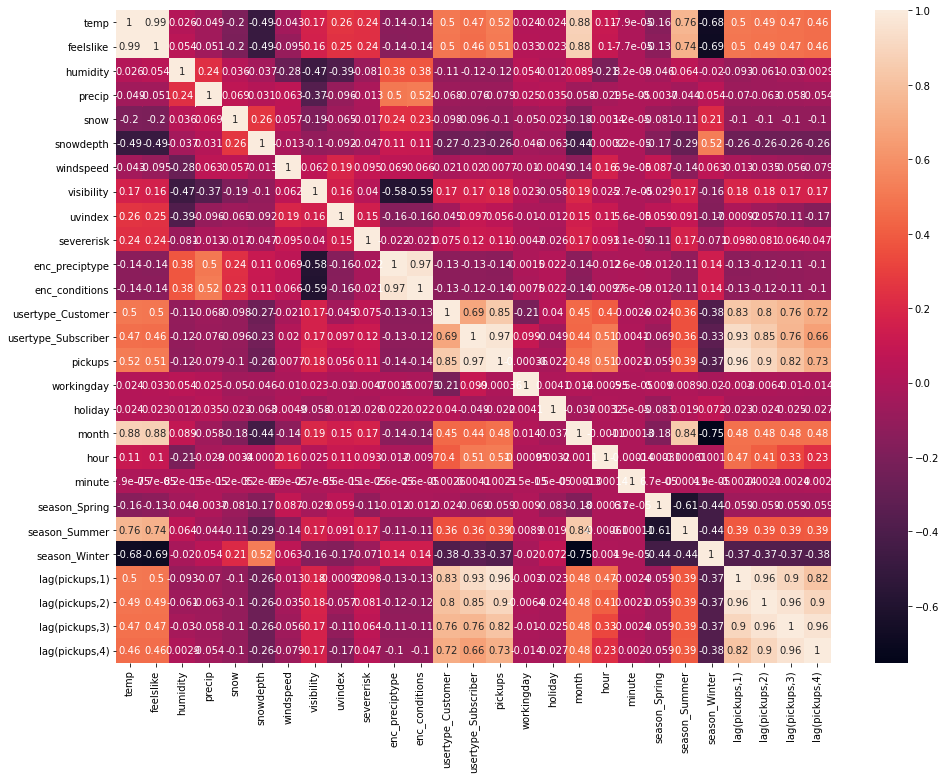

In [52]:
plt.figure(figsize=(16,12))
sns.heatmap(picksup.corr(), annot=True)

In [53]:
picksup.head(10)

,temp,feelslike,humidity,precip,snow,snowdepth,windspeed,visibility,uvindex,severerisk,...,month,hour,minute,season_Spring,season_Summer,season_Winter,"lag(pickups,1)","lag(pickups,2)","lag(pickups,3)","lag(pickups,4)"
4,7.2,6.0,96.49,0.0,0.0,0.0,7.3,4.0,0.0,10.0,...,1,2,0,0,0,1,49.0,43.0,59.0,66.0
5,7.2,6.0,96.49,0.0,0.0,0.0,7.3,4.0,0.0,10.0,...,1,2,30,0,0,1,41.0,49.0,43.0,59.0
6,7.2,7.2,96.60,0.0,0.0,0.0,0.1,1.0,0.0,10.0,...,1,3,0,0,0,1,32.0,41.0,49.0,43.0
7,7.2,7.2,96.60,0.0,0.0,0.0,0.1,1.0,0.0,10.0,...,1,3,30,0,0,1,42.0,32.0,41.0,49.0
8,6.8,5.4,99.79,0.0,0.0,0.0,7.4,0.0,0.0,10.0,...,1,4,0,0,0,1,53.0,42.0,32.0,41.0
9,6.8,5.4,99.79,0.0,0.0,0.0,7.4,0.0,0.0,10.0,...,1,4,30,0,0,1,40.0,53.0,42.0,32.0
10,6.8,5.0,99.85,0.0,0.0,0.0,9.0,0.0,0.0,10.0,...,1,5,0,0,0,1,51.0,40.0,53.0,42.0
11,6.8,5.0,99.85,0.0,0.0,0.0,9.0,0.0,0.0,10.0,...,1,5,30,0,0,1,42.0,51.0,40.0,53.0
12,7.3,5.6,99.54,0.0,0.0,0.0,8.9,0.1,0.0,10.0,...,1,6,0,0,0,1,82.0,42.0,51.0,40.0
13,7.3,5.6,99.54,0.0,0.0,0.0,8.9,0.1,0.0,10.0,...,1,6,30,0,0,1,100.0,82.0,42.0,51.0


/home/georgep/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pickups', ylabel='Density'>

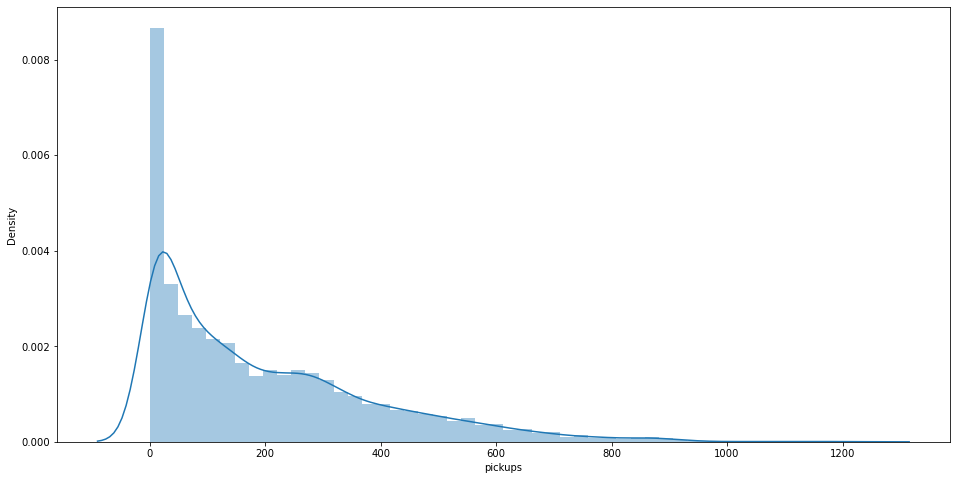

In [54]:
plt.figure(figsize=(16,8))
sns.distplot(picksup['pickups'])

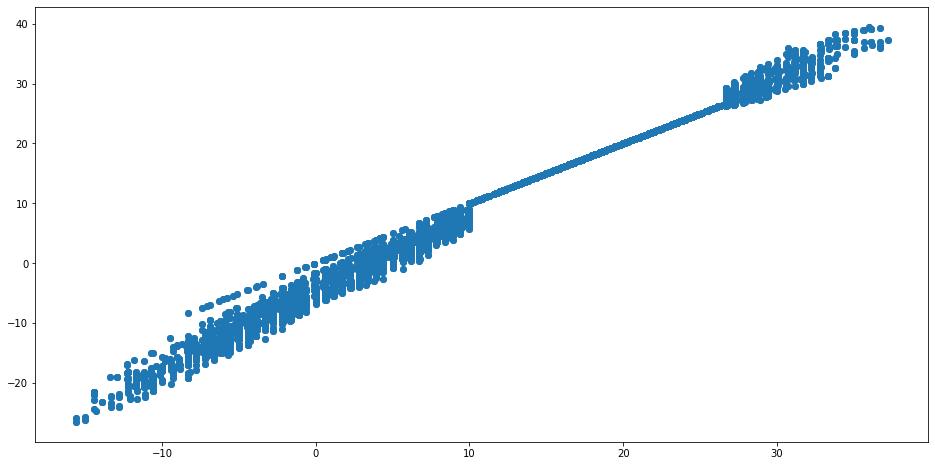

In [55]:
plt.figure(figsize=(16,8))
plt.scatter(picksup['temp'],picksup['feelslike'])

In [56]:
def scatter_plot():
    for i in picksup.columns:
        plt.scatter(picksup[i],picksup['pickups'])
        plt.title(f"Scatter plot for {i}")
        plt.show()

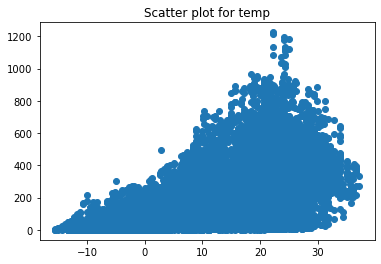

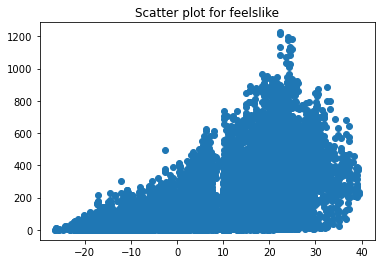

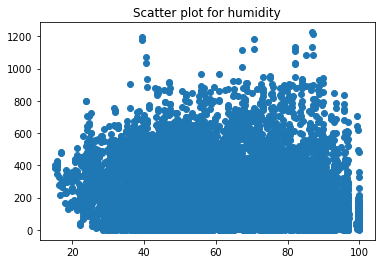

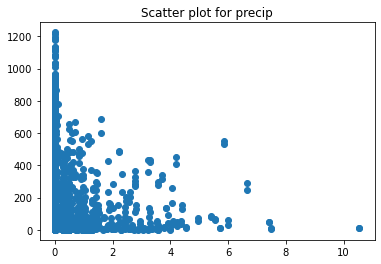

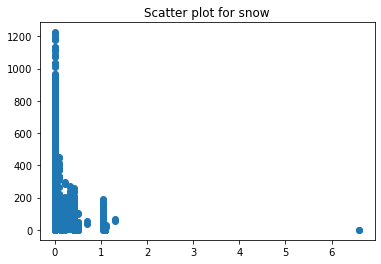

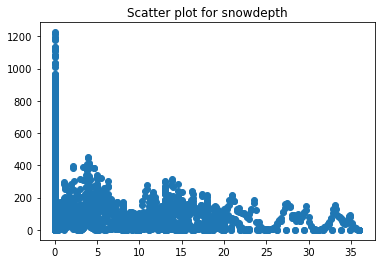

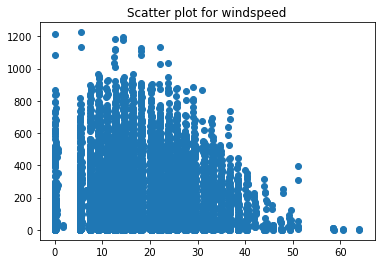

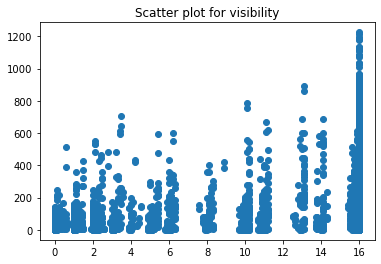

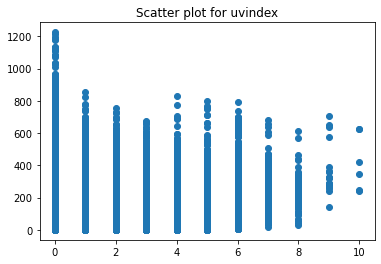

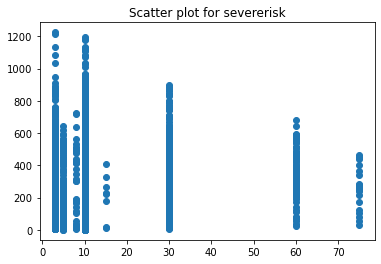

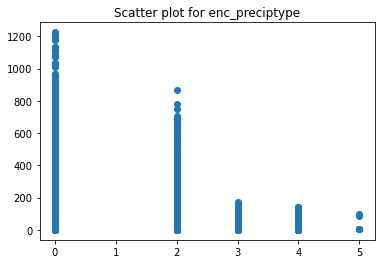

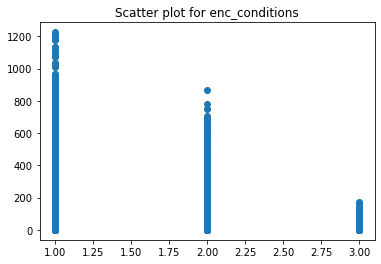

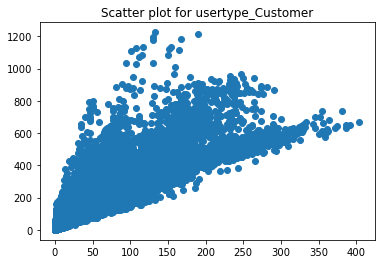

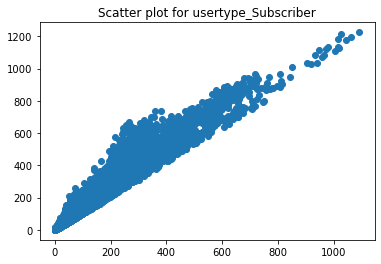

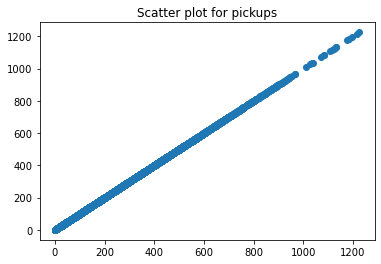

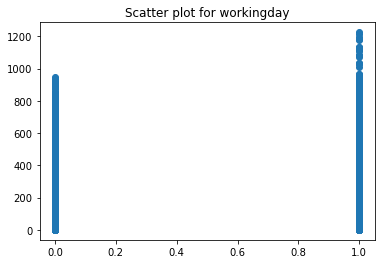

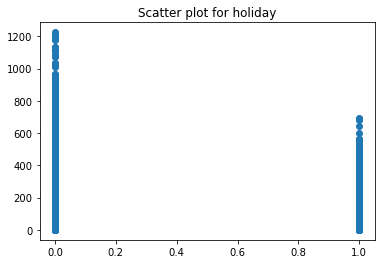

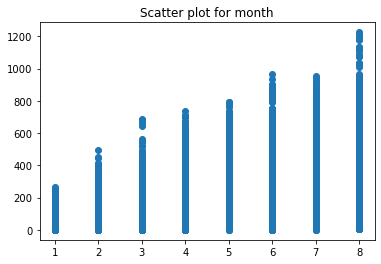

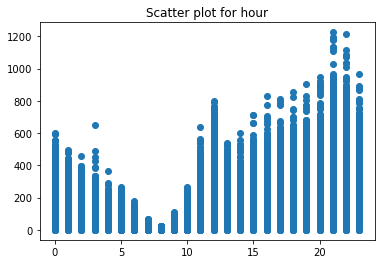

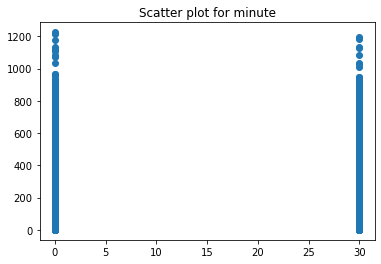

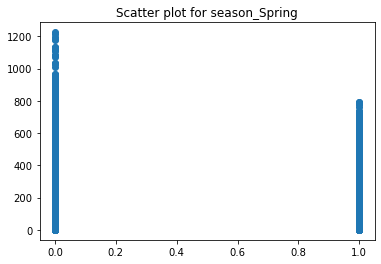

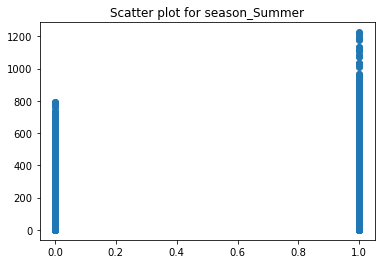

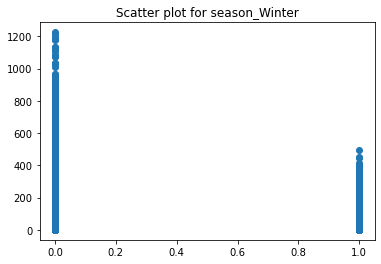

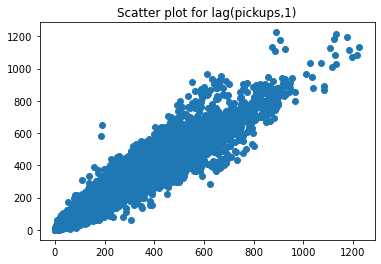

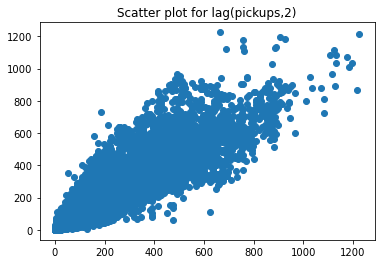

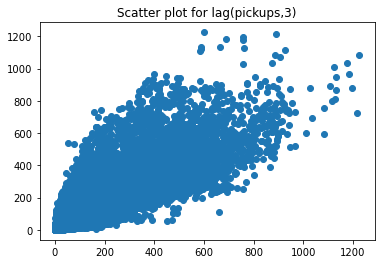

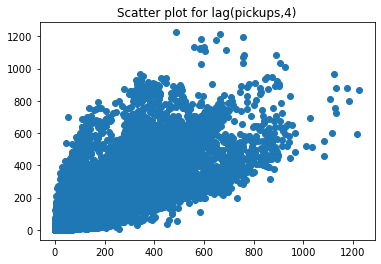

In [57]:
scatter_plot()

In [58]:
df30

,usertype_Customer,usertype_Subscriber,pickups
starttime,,,
2022-01-01 00:00:00,13.0,53.0,66.0
2022-01-01 00:30:00,15.0,44.0,59.0
2022-01-01 01:00:00,11.0,32.0,43.0
2022-01-01 01:30:00,20.0,29.0,49.0
2022-01-01 02:00:00,19.0,22.0,41.0
...,...,...,...
2022-08-31 21:30:00,130.0,1064.0,1194.0
2022-08-31 22:00:00,111.0,958.0,1069.0
2022-08-31 22:30:00,95.0,942.0,1037.0


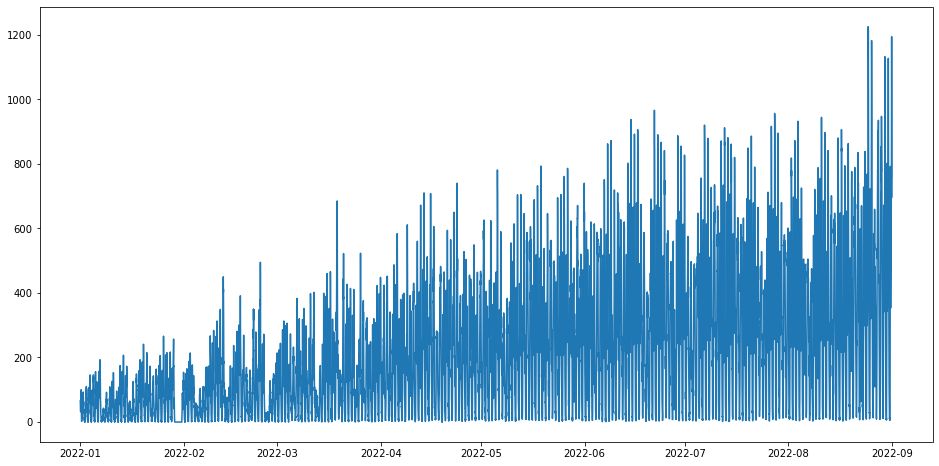

In [59]:
plt.figure(figsize=(16,8))
plt.plot(df30["pickups"])
plt.show()

<AxesSubplot:xlabel='hour', ylabel='pickups'>

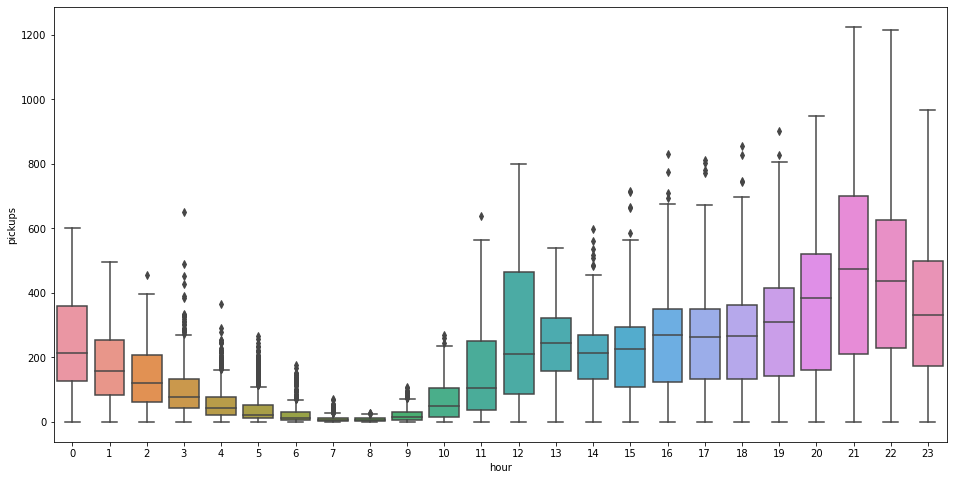

In [60]:
plt.figure(figsize=(16,8))
sns.boxplot(x='hour',y='pickups', data=picksup)

<AxesSubplot:xlabel='month', ylabel='pickups'>

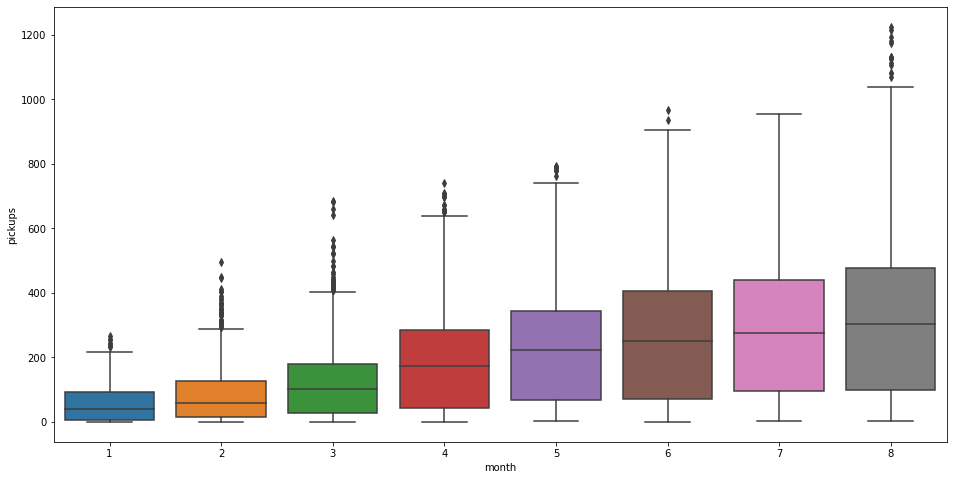

In [61]:
plt.figure(figsize=(16,8))
sns.boxplot(x='month',y='pickups', data=picksup)

<Figure size 1152x576 with 0 Axes>

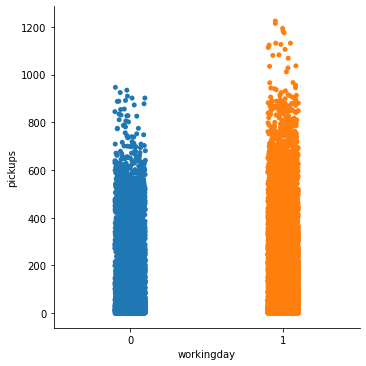

In [62]:
plt.figure(figsize=(16,8))
sns.catplot(data=picksup, x='workingday', y='pickups')

<Figure size 1152x576 with 0 Axes>

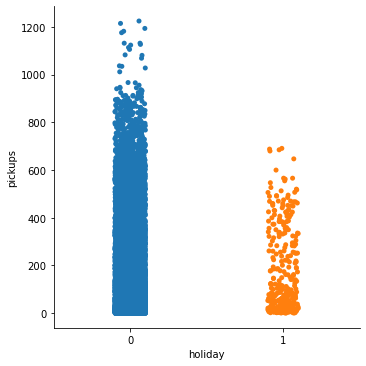

In [63]:
plt.figure(figsize=(16,8))
sns.catplot(data=picksup, x='holiday', y='pickups')

<AxesSubplot:xlabel='enc_conditions', ylabel='pickups'>

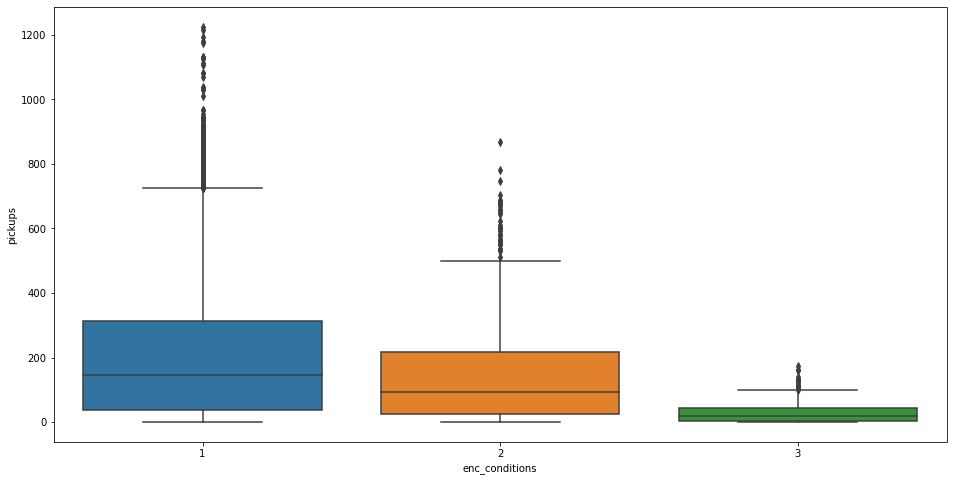

In [64]:
plt.figure(figsize=(16,8))
sns.boxplot(data=picksup, x='enc_conditions', y='pickups')

## MODELLING

In [65]:
picksup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11659 entries, 4 to 11662
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   temp                 11659 non-null  float64
 1   feelslike            11659 non-null  float64
 2   humidity             11659 non-null  float64
 3   precip               11659 non-null  float64
 4   snow                 11659 non-null  float64
 5   snowdepth            11659 non-null  float64
 6   windspeed            11659 non-null  float64
 7   visibility           11659 non-null  float64
 8   uvindex              11659 non-null  float64
 9   severerisk           11659 non-null  float64
 10  enc_preciptype       11659 non-null  int64  
 11  enc_conditions       11659 non-null  int64  
 12  usertype_Customer    11659 non-null  float64
 13  usertype_Subscriber  11659 non-null  float64
 14  pickups              11659 non-null  float64
 15  workingday           11659 non-null 

In [66]:
picksup['severerisk'].unique()

array([10.,  3.,  5., 30., 15.,  8., 60., 75.])

In [75]:
picksup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11663 entries, 0 to 11662
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   temp                 11663 non-null  float64
 1   feelslike            11663 non-null  float64
 2   humidity             11663 non-null  float64
 3   precip               11663 non-null  float64
 4   snow                 11663 non-null  float64
 5   snowdepth            11663 non-null  float64
 6   windspeed            11663 non-null  float64
 7   visibility           11663 non-null  float64
 8   uvindex              11663 non-null  float64
 9   severerisk           11663 non-null  float64
 10  enc_preciptype       11663 non-null  int64  
 11  enc_conditions       11663 non-null  int64  
 12  usertype_Customer    11663 non-null  float64
 13  usertype_Subscriber  11663 non-null  float64
 14  pickups              11663 non-null  float64
 15  workingday           11663 non-null 

In [84]:
picksup.head()

,temp,feelslike,humidity,precip,snow,snowdepth,windspeed,visibility,uvindex,severerisk,...,month,hour,minute,season_Spring,season_Summer,season_Winter,"lag(pickups,1)","lag(pickups,2)","lag(pickups,3)","lag(pickups,4)"
0,7.8,7.8,92.50,0.0,0.0,0.0,0.1,8.0,0.0,10.0,...,1,0,0,0,0,1,NaN,NaN,NaN,NaN
1,7.8,7.8,92.50,0.0,0.0,0.0,0.1,8.0,0.0,10.0,...,1,0,30,0,0,1,66.0,NaN,NaN,NaN
2,7.2,6.5,96.49,0.0,0.0,0.0,5.3,5.1,0.0,10.0,...,1,1,0,0,0,1,59.0,66.0,NaN,NaN
3,7.2,6.5,96.49,0.0,0.0,0.0,5.3,5.1,0.0,10.0,...,1,1,30,0,0,1,43.0,59.0,66.0,NaN
4,7.2,6.0,96.49,0.0,0.0,0.0,7.3,4.0,0.0,10.0,...,1,2,0,0,0,1,49.0,43.0,59.0,66.0


In [180]:
X = picksup.drop(['pickups','usertype_Subscriber','usertype_Customer','enc_preciptype','enc_conditions','precip','snow', 'windspeed', 'uvindex', 'severerisk'], axis=1)
y = picksup[['month','hour','pickups']]

In [181]:
X.head()

,temp,feelslike,humidity,snowdepth,visibility,workingday,holiday,month,hour,minute,season_Spring,season_Summer,season_Winter,"lag(pickups,1)","lag(pickups,2)","lag(pickups,3)","lag(pickups,4)"
0,7.8,7.8,92.50,0.0,8.0,0,1,1,0,0,0,0,1,NaN,NaN,NaN,NaN
1,7.8,7.8,92.50,0.0,8.0,0,1,1,0,30,0,0,1,66.0,NaN,NaN,NaN
2,7.2,6.5,96.49,0.0,5.1,0,1,1,1,0,0,0,1,59.0,66.0,NaN,NaN
3,7.2,6.5,96.49,0.0,5.1,0,1,1,1,30,0,0,1,43.0,59.0,66.0,NaN
4,7.2,6.0,96.49,0.0,4.0,0,1,1,2,0,0,0,1,49.0,43.0,59.0,66.0


In [182]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
scaling_columns = ['temp', 'feelslike', 'humidity', 'snowdepth', 'visibility','lag(pickups,1)', 'lag(pickups,2)',
       'lag(pickups,3)', 'lag(pickups,4)']
X[scaling_columns] = sc_X.fit_transform(X[scalin_columns])

In [183]:
X.head()

,temp,feelslike,humidity,snowdepth,visibility,workingday,holiday,month,hour,minute,season_Spring,season_Summer,season_Winter,"lag(pickups,1)","lag(pickups,2)","lag(pickups,3)","lag(pickups,4)"
0,-0.411403,-0.208096,1.483019,-0.375176,-1.938007,0,1,1,0,0,0,0,1,NaN,NaN,NaN,NaN
1,-0.411403,-0.208096,1.483019,-0.375176,-1.938007,0,1,1,0,30,0,0,1,-0.670956,NaN,NaN,NaN
2,-0.465669,-0.305023,1.680284,-0.375176,-2.756220,0,1,1,1,0,0,0,1,-0.706651,-0.671088,NaN,NaN
3,-0.465669,-0.305023,1.680284,-0.375176,-2.756220,0,1,1,1,30,0,0,1,-0.788240,-0.706809,-0.671247,NaN
4,-0.465669,-0.342303,1.680284,-0.375176,-3.066576,0,1,1,2,0,0,0,1,-0.757644,-0.788458,-0.706997,-0.671528


In [184]:
X[['workingday', 'holiday', 'month', 'hour', 'minute',
'season_Spring', 'season_Summer', 'season_Winter']] = X[['workingday', 'holiday', 'month', 'hour', 'minute',
                                                               'season_Spring', 'season_Summer', 'season_Winter']].astype('category')

In [185]:
def TrainingAndTestData(X,y,predict_time,predict_month):
    X_test = X[(X['hour']==predict_time-2) & (X['month']==predict_month)]
    y_test = y[(y['hour']==predict_time) & (y['month']==predict_month)]['pickups']
    X_train = X[(~X['hour'].isin([predict_time-2])) & ((X['month']!=predict_month))]
    y_train = y[(~y['hour'].isin([predict_time])) & (y['month']!=predict_month)]
    
    train_sequence = {}
    for time in list(X_train['hour'].unique()):
        train_sequence[time] = [X_train[X_train['hour']==time].values, y_train[y_train['hour']==time+2]['pickups'].values] 
    
    return X_test, y_test, X_train, y_train, train_sequence

In [186]:
X_test, y_test, X_train, y_train, train_sequence = TrainingAndTestData(X,y, 18, 8)

In [187]:
X_train.head()

,temp,feelslike,humidity,snowdepth,visibility,workingday,holiday,month,hour,minute,season_Spring,season_Summer,season_Winter,"lag(pickups,1)","lag(pickups,2)","lag(pickups,3)","lag(pickups,4)"
0,-0.411403,-0.208096,1.483019,-0.375176,-1.938007,0,1,1,0,0,0,0,1,NaN,NaN,NaN,NaN
1,-0.411403,-0.208096,1.483019,-0.375176,-1.938007,0,1,1,0,30,0,0,1,-0.670956,NaN,NaN,NaN
2,-0.465669,-0.305023,1.680284,-0.375176,-2.756220,0,1,1,1,0,0,0,1,-0.706651,-0.671088,NaN,NaN
3,-0.465669,-0.305023,1.680284,-0.375176,-2.756220,0,1,1,1,30,0,0,1,-0.788240,-0.706809,-0.671247,NaN
4,-0.465669,-0.342303,1.680284,-0.375176,-3.066576,0,1,1,2,0,0,0,1,-0.757644,-0.788458,-0.706997,-0.671528


In [267]:
LRM = LinearRegression()
#log_ytest, log_ytrain = np.log1p(y_test), np.log1p(y_train)  # Log Transformation of Target Value y
LRM.fit(X_train, y_train) 

# Step 3 : Predict
preds = LRM.predict(X_test)

# Step 4 : Evaluate
print ('Linear Regression test RMSE:', mean_squared_error(y_test, preds))
print ('Linear Regression test R^2:', r2_score(y_test, preds))
       
print ('Linear Regression train RMSE:', mean_squared_error(y_train, LRM.predict(X_train)))
print ('Linear Regression train R^2:', r2_score(y_train, LRM.predict(X_train)))

Linear Regression test RMSE: 88750.37286614206
Linear Regression test R^2: -2.083279292663338
Linear Regression train RMSE: 1362.6139989586914
Linear Regression train R^2: 0.9184331560390181


In [ ]:
# Step 1: Create Model
RM = Ridge()

# Step 2-1 : Create GridSearchCV Object
# Hyper-parameter List
ridge_params = {'max_iter':[3000], 'alpha':[0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}
# Evaluate Function for Cross-Validation (RMSLE score)
rmsle_scorer = make_scorer(rmsle, greater_is_better=False) 
# Create GridSearchCV Object (with Ridge)
gridsearch_RM = GridSearchCV(estimator=RM,
                                      param_grid=ridge_params,
                                      scoring=rmsle_scorer,
                                      cv=5)

# Step 2-2 : Perform Grid Search
#log_y = np.log1p(y) # Log Transformation of Target Value y
gridsearch_RM.fit(X_train, log_ytrain) # Train (Grid Search)

print('Best Parameter:', gridsearch_RM.best_params_)

# Step 3 : Predict
preds = gridsearch_RM.best_estimator_.predict(X_test)

# Step 4 : Evaluate
print('Ridge Regression RMSLE:', mean_squared_log_error(log_ytest, preds))

In [ ]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

In [ ]:
rf_prediction = rf.predict(X_test)

In [ ]:
print('RMSE:',np.sqrt(mean_squared_error(y_test, rf_prediction)))

In [ ]:
plt.scatter(log_ytest,rf_prediction, c='crimson', marker='o')

In [ ]:
r2_score(y_test,rf_prediction)

In [ ]:
r2_score(y_train,rf.predict(X_train))

In [ ]:
plt.scatter(y_train,rf.predict(X_train), c='crimson', marker='o')